In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


Load and preprocess dataset

In [10]:
def load_mnist(binary_classification=True):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    if binary_classification:
        train = [(x, float(y == 0)) for x, y in train]
        test = [(x, float(y == 0)) for x, y in test]

    train_loader = DataLoader(train, batch_size=64, shuffle=True)
    test_loader = DataLoader(test, batch_size=64, shuffle=False)
    return train_loader, test_loader


Logistic Regression Model

In [11]:
class LogisticRegressionModel:
    def __init__(self, input_dim):
        self.w = np.zeros((input_dim, 1))
        self.b = 0

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        return self.sigmoid(X @ self.w + self.b)

    def loss(self, X, y):
        m = len(y)
        preds = self.predict(X)
        loss = -np.mean(y * np.log(preds + 1e-8) + (1 - y) * np.log(1 - preds + 1e-8))
        return loss

    def gradient(self, X, y):
        m = len(y)
        preds = self.predict(X)
        error = preds - y
        dw = (X.T @ error) / m
        db = np.mean(error)
        return dw, db

 SGD Optimizer (Student: extend this)

In [12]:
def sgd_train(model, train_loader, lr=0.01, num_epochs=10):
    loss_history = []

    for epoch in range(num_epochs):
        for batch in train_loader:
            x_batch, y_batch = batch
            X = x_batch.numpy()
            y = y_batch.numpy().reshape(-1, 1)

            dw, db = model.gradient(X, y)
            model.w -= lr * dw
            model.b -= lr * db

            loss = model.loss(X, y)
            loss_history.append(loss)

    return loss_history

SGD-Momentum

In [13]:
def sgd_momentum_train(model, train_loader, lr=0.01, num_epochs=10, beta=0.9):
    loss_history = []
    v_w = np.zeros_like(model.w)
    v_b = 0

    for epoch in range(num_epochs):
        for batch in train_loader:
            x_batch, y_batch = batch
            X = x_batch.numpy()
            y = y_batch.numpy().reshape(-1, 1)

            dw, db = model.gradient(X, y)

            # Update velocities
            v_w = beta * v_w + (1 - beta) * dw
            v_b = beta * v_b + (1 - beta) * db

            # Update parameters
            model.w -= lr * v_w
            model.b -= lr * v_b

            loss = model.loss(X, y)
            loss_history.append(loss)

    return loss_history

SGD-Adam 

In [14]:
def sgd_adam_train(model, train_loader, lr=0.01, num_epochs=10, beta1=0.9, beta2=0.999, epsilon=1e-8):
    loss_history = []
    m_w = np.zeros_like(model.w)
    v_w = np.zeros_like(model.w)
    m_b = 0
    v_b = 0
    t = 0

    for epoch in range(num_epochs):
        for batch in train_loader:
            x_batch, y_batch = batch
            X = x_batch.numpy()
            y = y_batch.numpy().reshape(-1, 1)

            dw, db = model.gradient(X, y)

            # Increment timestep
            t += 1

            # Update biased first moment estimate
            m_w = beta1 * m_w + (1 - beta1) * dw
            m_b = beta1 * m_b + (1 - beta1) * db

            # Update biased second raw moment estimate
            v_w = beta2 * v_w + (1 - beta2) * (dw ** 2)
            v_b = beta2 * v_b + (1 - beta2) * (db ** 2)

            # Compute bias-corrected first moment estimate
            m_w_hat = m_w / (1 - beta1 ** t)
            m_b_hat = m_b / (1 - beta1 ** t)

            # Compute bias-corrected second raw moment estimate
            v_w_hat = v_w / (1 - beta2 ** t)
            v_b_hat = v_b / (1 - beta2 ** t)

            # Update parameters
            model.w -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
            model.b -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

            loss = model.loss(X, y)
            loss_history.append(loss)

    return loss_history

Plotting and Evaluation

In [15]:
def plot_loss(losses, label='SGD'):
    plt.plot(losses, label=label)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss vs Iteration")
    plt.legend()

 Main Function

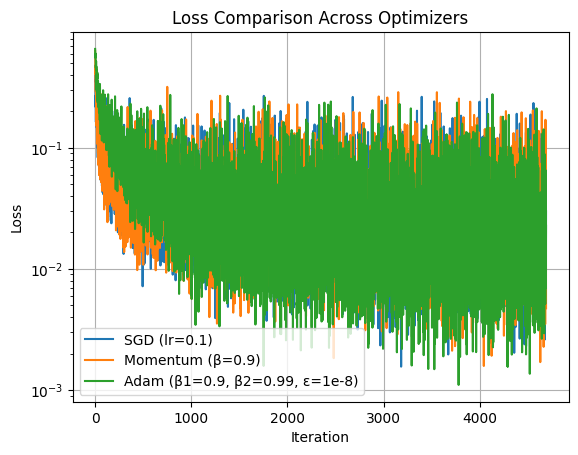

In [16]:
if __name__ == '__main__':
    train_loader, test_loader = load_mnist()
    input_dim = 28 * 28

    # Vanilla SGD
    model_sgd = LogisticRegressionModel(input_dim=input_dim)
    loss_sgd = sgd_train(model_sgd, train_loader, lr=0.1, num_epochs=5)
    plot_loss(loss_sgd, label='SGD (lr=0.1)')

    # SGD + Momentum
    model_momentum = LogisticRegressionModel(input_dim=input_dim)
    loss_momentum = sgd_momentum_train(model_momentum, train_loader, lr=0.1, num_epochs=5, beta=0.9)
    plot_loss(loss_momentum, label='Momentum (β=0.9)')

    # Adam Optimizer
    model_adam = LogisticRegressionModel(input_dim=input_dim)
    loss_adam = sgd_adam_train(model_adam, train_loader, lr=0.001, num_epochs=5, beta1=0.9, beta2=0.99, epsilon=1e-8)
    plot_loss(loss_adam, label='Adam (β1=0.9, β2=0.99, ε=1e-8)')

    plt.title("Loss Comparison Across Optimizers")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.yscale('log')
    plt.grid(True)
    plt.show()
